# Assignment 4: Attention

In [2]:
import torch
import torch.nn as nn
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import PackedSequence, pad_sequence, pack_sequence, pad_packed_sequence, pack_padded_sequence
from torch.utils.data import DataLoader
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast

import os

# Below helps to run tokenizer with multiprocessing
os.environ["TOKENIZERS_PARALLELISM"] = "true"


#### Vectorization

In [1]:
'''
This is the example of vectorization of dot product for two different sequence length.
'''

e_states = torch.randn(10, 100, 16)
d_states = torch.randn(10, 80, 16)

dot_product = torch.bmm(e_states, d_states.permute(0,2,1))

NameError: name 'torch' is not defined

In [149]:
class AttentionTranslator(Translator):
  def __init__(self, src_tokenizer, tgt_tokenizer, hidden_size=256):
    super().__init__(src_tokenizer, tgt_tokenizer, hidden_size)
    self.decoder_proj = nn.Linear(hidden_size * 2, tgt_tokenizer.vocab_size)
  
  def get_attention(self, e_states, d_states, mask):
    '''
    Arguments:
      e_states (torch.Tensor or torch.nn.utils.rnn.PackedSequence): Encoder's hidden states over timestep of source sentence. Has shape of [N x Ts x C]
      d_states (torch.Tensor or torch.nn.utils.rnn.PackedSequence): Decoder's hidden states over timestep of target sentence. Has shape of [N x Tt x C]
      mask (torch.Tensor): Boolean Tensor with a shape of [N x Ts]. The value of mask is True only if mask[n, t] is a padded value and otherwise False.
    
      N is number of sequence in the batch (batch size)
      Ts is (maximum) length of source sentence (number of tokens)
      Tt is (maximum) length of target sentence (number of tokens)
      C is a hidden size
       
    Output:
      weighted_sum (torch.Tensor or torch.nn.utils.rnn.PackedSequence):
    
    Caution:
      e_states and d_states has different number of timeteps.
      The attention score (dot product value) has to have a shape of [N, Ts, Tt].
      
      
      
    
    TODO: Complete this function
    '''
    is_packed = isinstance(e_states, PackedSequence)
    if is_packed:
      e_states, x_batch_len = pad_packed_sequence(e_states, batch_first=True)
      d_states, y_batch_len = pad_packed_sequence(d_states, batch_first=True)
    
    '''
    Write your code from here
    '''
    
    e_states = e_states.unsqueeze(2)
    d_states = d_states.unsqueeze(1)

    attention_score = (e_states * d_states).sum(-1)
    attention_score[mask] = -1e10
    
    attention_weight = torch.softmax(attention_score, dim=1)
    weighted_sum = (e_states * attention_weight.unsqueeze(-1)).sum(1)
    
    '''
    Leave the codes below.
    '''
    if is_packed:
      weighted_sum = pack_padded_sequence(weighted_sum, y_batch_len, batch_first=True, enforce_sorted=False)
    return weighted_sum
  
  def forward(self, x, y):
    e_out_by_time, e_last_hidden  = self.run_encoder(x)
    d_out_by_time = self.run_decoder(y, e_last_hidden)
    
    mask = pad_packed_sequence(x, batch_first=True)[0] == 0
    
    weighted_sum = self.get_attention(e_out_by_time, d_out_by_time, mask)
    
    if isinstance(y, PackedSequence):
      logit = self.decoder_proj(torch.cat([weighted_sum.data, d_out_by_time.data], dim=-1))
    else:
      logit = self.decoder_proj(d_out_by_time)  # Num_batch x Num_timesteps x Num_vocab
    
    probs = torch.softmax(logit, dim=-1)
    
    if isinstance(y, PackedSequence):
      out_seq = PackedSequence(probs, 
                               batch_sizes=y.batch_sizes, 
                               sorted_indices=y.sorted_indices, 
                               unsorted_indices=y.unsorted_indices)
      return out_seq
    else:
      return probs
    

model = AttentionTranslator(src_tokenizer, tgt_tokenizer, 512)

model(batch[0], batch[1])

PackedSequence(data=tensor([[3.2446e-05, 3.0685e-05, 3.2470e-05,  ..., 3.1739e-05, 3.2247e-05,
         3.0203e-05],
        [3.1138e-05, 3.0794e-05, 3.1492e-05,  ..., 3.1710e-05, 3.2674e-05,
         3.0614e-05],
        [3.1536e-05, 3.1345e-05, 3.1711e-05,  ..., 3.1519e-05, 3.2388e-05,
         2.9582e-05],
        ...,
        [3.3579e-05, 3.2189e-05, 2.8717e-05,  ..., 3.1391e-05, 3.2227e-05,
         3.0350e-05],
        [3.3719e-05, 3.1734e-05, 2.9376e-05,  ..., 3.1516e-05, 3.2870e-05,
         3.0839e-05],
        [3.3823e-05, 3.1278e-05, 3.0300e-05,  ..., 3.1402e-05, 3.3366e-05,
         3.1277e-05]], grad_fn=<SoftmaxBackward0>), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 63, 61, 58, 56, 53, 51, 50, 49, 47, 46, 45,
        44, 42, 40, 38, 36, 36, 34, 34, 32, 32, 30, 29, 29, 28, 28, 27, 24, 22,
        20, 17, 16, 16, 16, 15, 14, 13, 10, 10,  9,  9,  8,  5,  5,  4,  4,  4,
         4,  3,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1]), sorted_indices=tensor([57, 41

In [153]:
model = AttentionTranslator(src_tokenizer, tgt_tokenizer, 512)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model, optimizer, get_cross_entropy_loss, train_loader, valid_loader, 'cuda', 'nmt_attention_512')

In [154]:
trainer.train_by_num_epoch(20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/22534 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 3.47 GiB (GPU 0; 23.69 GiB total capacity; 6.45 GiB already allocated; 2.92 GiB free; 9.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

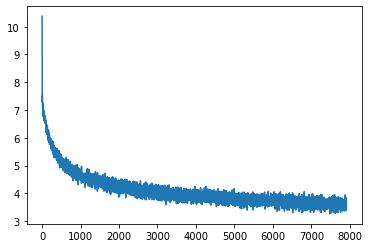

In [158]:
plt.plot(trainer.training_loss)

## Problem 1: Implement Dot Product Attention

- Optimizing computation time is really important
    - Use `torch.mm()` or `torch.matmul()`
    - `torch.mm(a, b)` is a function for calculating matrix multiplcation of two matrices `a` and `b`
        - `a` and `b` has to be 2-dim tensors
        - `a.shape[1]` has to be equal to `b.shape[0]`
    - `torch.matmul()` is a function for matrix multiplication but with broadcasting
        - https://pytorch.org/docs/stable/generated/torch.matmul.html
        - It has less restriction on its input shape.
            - It automatically matches the dimension of two tensors following some rules
            - Therefore, it is a bit risky to use this funciton if you don't understand how it works

### Hint: Dot product as matrix multiplcation.

- Let's say there are two vector, $u=\begin{bmatrix}-3 \\ 2 \\ 1\end{bmatrix}$ and $v = \begin{bmatrix} 5 \\ 4 \\ 6\end{bmatrix}$
    - The dot product of the two vectors is $(-3 \times 5) + (2 \times 4) + (1 \times 6) = 1$
    - It is equivalent to $u^T \times v$
        - In this case $u\in\mathbb{R}^{3x1}$ and $v\in\mathbb{R}^{3x1}$
- In PyTorch, this can be described as below:
    - `u = torch.Tensor([-3, 2, 1])`
    - `v = torch.Tensor([5, 4, 6])`
    - Dot product of u and v can be calculated by one of belows:
        - `torch.mm(u.unsqueeze(0), v.unsqueeze(1))`
            - `u.unsqueeze(0).shape == [1, 3]`
            - `v.unsqueeze(1).shape == [3, 1]`
            - `unsqueeze()` returns a new tensor with a dimension of size one inserted at the specified position.
            - The result has shape of [1,1]
        - `torch.matmul(u, v)`
        - `u @ v`
            - `@` denotes matrix multiplication, which was introduced from Python 3.5
        - `(u * v).sum()`
            - This will be much slower than others, because it first do element-wise multiplcation

In [82]:
'''
Hint: Dot product as matrix multiplcation.
'''

u = torch.Tensor([-3, 2, 1])
v = torch.Tensor([5, 4, 6])

print(f"Result of (u * v).sum() is {(u * v).sum()}. This computation is much slower than others because it use element-wise multiplication instead of matrix multiplication") 
print(f"Result of torch.mm(u.unsqueeze(0), v.unsqueeze(1)) is {torch.mm(u.unsqueeze(0), v.unsqueeze(1))}")
print(f"Result of torch.matmul(u, v) is {torch.matmul(u, v)}")
print(f"Result of u @ v is {u @ v}")

Result of (u * v).sum() is -1.0. This computation is much slower than others because it use element-wise multiplication instead of matrix multiplication
Result of torch.mm(u.unsqueeze(0), v.unsqueeze(1)) is tensor([[-1.]])
Result of torch.matmul(u, v) is -1.0
Result of u @ v is -1.0


In [3]:
def get_attention_score_for_a_single_query(keys, query):
  '''
  This function returns an attention score for each vector in keys for a given query.
  You can regard 'keys' as hidden states over timestep of Encoder, while query is a hidden state of specific time step of Decoder
  Name 'keys' are used because it is used for calculating attention score (match rate between given vector and query).
  
  For every C-dimensional vector key, the attention score is a dot product between the key and the query vector.
  
  Arguments:
    keys (torch.Tensor): Has a shape of [T, C]. These are vectors that a query wants attend to
    query (torch.Tensor): Has a shape of [C]. This is a vector that attends to other set of vectors (keys and values)
  
  Output:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [T]
                                    
    attention_score[i] has to be a dot product value between keys[i] and query                                 


  TODO: Complete this sentence using torch.mm (matrix multiplication)
  Hint: You can use atensor.unsqueeze(dim) to expand a dimension (with a diemsion of length 1) without changing item value of the tensor.
  '''
  
  return


torch.manual_seed(0)
num_t = 23
h_size = 16

keys = torch.randn(num_t, h_size)
query = torch.randn(h_size)

att_score = get_attention_score_for_a_single_query(keys, query)
att_score

In [60]:
'''
Test Case
'''
assert att_score.ndim == 1 and len(att_score) == num_t, "Error: Check output shape"
answer = torch.Tensor([-3.0786,  2.1729,  1.7950, -5.0503,  3.3254,  0.2828, -0.9800, -1.8868,
         0.2550,  2.9389, -0.1799, -1.0586,  0.1465, -0.9441,  0.8888, -3.8108,
        -2.5662, -1.1660, -2.2327,  2.7087, -0.5800,  8.7984,  4.3816])
assert torch.max(torch.abs(att_score-answer)) < 1e-4, "Error: The output value is different"
print("Passed all the cases!")

Passed all the cases!


In [4]:
def get_attention_weight_from_score(attention_score):
  '''
  This function converts attention score to attention weight.
  
  Argument:
    attention_score (torch.Tensor): Tensor of real number. Has a shape of [T]

  Output:
    attention_weight (torch.Tensor): Tensor of real number between 0 and 1. Sum of attention_weight is 1. Has a shape of [T]
  
  TODO: Complete this function
  '''
  assert attention_score.ndim == 1
  
  return

att_weight = get_attention_weight_from_score(att_score)
att_weight

AttributeError: 'NoneType' object has no attribute 'ndim'

In [58]:
answer = torch.Tensor([0.0000,     0.0013,     0.0009,     0.0000,     0.0041,     0.0002,
            0.0001,     0.0000,     0.0002,     0.0028,     0.0001,     0.0001,
            0.0002,     0.0001,     0.0004,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0022,     0.0001,     0.9756,     0.0118])
assert att_weight.shape == att_score.shape, 'Shape has to be remained the same'
assert att_weight.sum() == 1, "Sum of attention weight has to be 1"
assert torch.max(torch.abs(att_weight-answer)) < 1e-4, "Error: The output value is different"

print("Passed all the cases!")


Passed all the cases


In [55]:
def get_weighted_sum(values, attention_weight):
  '''
  This function converts attention score to attention weight
  
  Argument:
    values (torch.Tensor): Has a shape of [T, C]. These are vectors that are used to form attention vector
    attention_weight: Has a shape of [T], which represents the weight for each vector to compose the attention vector

  Output:
    attention_vector (torch.Tensor): Weighted sum of values using the attention weight. Has a shape of [C]
  
  TODO: Complete this function using torch.mm
  '''
  return

att_vec = get_weighted_sum(keys, att_weight) # In simple dot-product-attention, key and value are the same
att_vec

tensor([ 0.6280,  3.8540, -0.1042,  0.3148,  0.3711, -0.5095, -0.9663,  1.3295,
         1.9003, -1.2611, -2.2939, -2.0338,  0.8757, -0.6726,  1.9071, -1.0711])

In [54]:
answer = torch.Tensor([ 0.6280,  3.8540, -0.1042,  0.3148,  0.3711, -0.5095, -0.9663,  1.3295,
         1.9003, -1.2611, -2.2939, -2.0338,  0.8757, -0.6726,  1.9071, -1.0711])
assert att_vec.shape == query.shape, 'Shape has to be remained the same'
assert torch.max(torch.abs(att_vec-answer)) < 1e-4, "Error: The output value is different"
print("Passed all the cases")


Passed all the cases


## Problem 2: Attention in Batch
- In this problem, you have to calculate attention with batch
- You can use `torch.bmm()` for batch matrix multiplication https://pytorch.org/docs/stable/generated/torch.bmm.html 
    - `torch.bmm()` takes two 3-dim tensor as its input
    - Each tensor has to be 3-dim (atensor.ndim==3)


In [107]:
'''
Hint for Problem 2

You can calculate matrix multiplication of matrices in batch effectively using torch.bmm() or torch.matmul()
'''

torch.manual_seed(0)
matrix_left1 = torch.randn(5, 3)
matrix_left2 = torch.randn(5, 3)

print(f"matrix_left1: \n{matrix_left1}")
print(f"matrix_left2: \n{matrix_left2}")

matrix_right1 = torch.randn(3, 4)
matrix_right2 = torch.randn(3, 4)
print(f"matrix_right1: \n{matrix_right1}")
print(f"matrix_right2: \n{matrix_right2}")

print("Let's assume that we have batch of matrix, which is stack of these two matices")
matrix_left = torch.stack([matrix_left1, matrix_left2])
matrix_right = torch.stack([matrix_right1, matrix_right2])

print(f"matrix_left: \n{matrix_left} \n which is shape of {matrix_left.shape}")
print(f"matrix_right: \n{matrix_right}\n which is shape of {matrix_right.shape}")


'''
Exhaustive method: using torch.mm() only with for loop (This is SLOW when matrix gets much larger)
'''

mm_forloop_output = []
for sample_index in range(matrix_left.shape[0]):
  mat_left = matrix_left[sample_index]
  mat_right = matrix_right[sample_index]
  
  mm_result = torch.mm(mat_left, mat_right)
  mm_forloop_output.append(mm_result)
  
mm_forloop_stack = torch.stack(mm_forloop_output)
print(f"mat_mul_stack: \n{mm_forloop_stack}\n which is shape of {mm_forloop_stack.shape}")


'''
Good method: using torch.bmm()
'''

mat_mul_bmm = torch.bmm(matrix_left, matrix_right)
print(f"mat_mul_bmm: \n{mat_mul_bmm}\n which is shape of {mat_mul_bmm.shape}")


matrix_left1: 
tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193],
        [-0.4033, -0.5966,  0.1820],
        [-0.8567,  1.1006, -1.0712]])
matrix_left2: 
tensor([[ 0.1227, -0.5663,  0.3731],
        [-0.8920, -1.5091,  0.3704],
        [ 1.4565,  0.9398,  0.7748],
        [ 0.1919,  1.2638, -1.2904],
        [-0.7911, -0.0209, -0.7185]])
matrix_right1: 
tensor([[ 0.5186, -1.3125,  0.1920,  0.5428],
        [-2.2188,  0.2590, -1.0297, -0.5008],
        [ 0.2734, -0.9181, -0.0404,  0.2881]])
matrix_right2: 
tensor([[-0.0075, -0.9145, -1.0886, -0.2666],
        [ 0.1894, -0.2190,  2.0576, -0.0354],
        [ 0.0627, -0.7663,  1.0993,  2.7565]])
Let's assume that we have batch of matrix, which is stack of these two matices
matrix_left: 
tensor([[[ 1.5410, -0.2934, -2.1788],
         [ 0.5684, -1.0845, -1.3986],
         [ 0.4033,  0.8380, -0.7193],
         [-0.4033, -0.5966,  0.1820],
         [-0.8567,  1.1006, -1.0712]],

   

In [5]:
def get_attention_score_for_a_batch_query(keys, query):
  '''
  This function returns a batch of attention score for each vector in (multi-batch) keys for a given (single-batch) query.
  You can regard 'keys' as hidden states over timestep of Encoder, while query is a hidden state of specific time step of Decoder
  Name 'keys' are used because it is used for calculating attention score (match rate between given vector and query).
  
  For every C-dimensional vector key, the attention score is a dot product between the key and the query vector.
  
  Arguments:
    keys (torch.Tensor): Has a shape of [N, T, C]. These are vectors that a query wants attend to
    query (torch.Tensor): Has a shape of [N, C]. This is a vector that attends to other set of vectors (keys and values)
  
  Output:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [N, T]
                                    
    attention_score[n, i] has to be a dot product value between keys[n, i] and query[n]                     
    
  TODO: Complete this function without using for loop
  Hint: Use torch.bmm or torch.matmul after make two input tensors as 3-dim tensors.

  '''
  return 

torch.manual_seed(0)
num_b = 6
num_t = 23
h_size = 16

keys = torch.randn(num_b,num_t, h_size)
query = torch.randn(num_b, h_size)
out = get_attention_score_for_a_batch_query(keys, query)

assert out.ndim == 2 and out.shape == torch.Size([num_b, num_t])

AttributeError: 'NoneType' object has no attribute 'ndim'

In [124]:
def get_attention_score_for_a_batch_multiple_query(keys, queries):
  '''
  Now you have to implement the attention score for not only single query, but multiple queries.
  
  This function returns a batch of attention score for each vector in keys for given queries.
  You can regard 'keys' as hidden states over timestep of Encoder, while querys are hidden states over timestep of Decoder
  Name 'keys' are used because it is used for calculating attention score (match rate between given vector and query).
  
  For every C-dimensional vector key, the attention score is a dot product between the key and the query vector.
  
  Arguments:
    keys (torch.Tensor): Has a shape of [N, Ts, C]. These are vectors that a query wants attend to
    queries (torch.Tensor): Has a shape of [N, Tt, C]. This is a vector that attends to other set of vectors (keys and values)
  
  Output:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [N, Ts, Tt]
                                    
    attention_score[n, i, t] has to be a dot product value between keys[n, i] and query[n, t] 
    
  TODO: Complete this function without using for loop
  HINT: Use torch.bmm() with proper transpose (permutation) of given tensors. (You can use atensor.permute())
        Think about which dimension (axis) of tensors has to be multiplied together and resolved (disappear) after matrix multiplication,
        and how the result tensor has to look like (shape)
  '''
  return

torch.manual_seed(0)
num_b = 6
num_ts = 23
num_tt = 14
h_size = 16

keys = torch.randn(num_b, num_ts, h_size)
queries = torch.randn(num_b, num_tt, h_size)
att_score = get_attention_score_for_a_batch_multiple_query(keys, queries)

att_score

tensor([[[  6.1462,   2.7917,   3.2981,  ...,  -1.7558,  -1.9945,   1.7817],
         [ -2.0761,   1.5621,  -4.6314,  ...,  -2.9616,   5.0151,  -0.5098],
         [ -3.7923,   0.6755,  -2.5517,  ...,  -6.6489,   2.2012,   0.5882],
         ...,
         [  2.9819,  12.6860,   6.7435,  ...,   3.5522,  -7.0258,   2.3800],
         [ -5.4682,  -2.9139,  -0.3054,  ...,   6.4960,  -1.4581, -12.5525],
         [ -1.0037,   1.1092,   1.3248,  ...,   2.8827,   3.8804,  -5.4968]],

        [[ -2.9907,  -0.1470,  -0.1703,  ...,   2.4992,  -1.8304,   1.1768],
         [-15.4518,   2.2430,   4.9486,  ...,   4.4271,  -4.3865,  -9.2907],
         [  4.2723,  -0.6171,   2.6252,  ...,  -2.2281,  -2.5648,  -4.1481],
         ...,
         [  1.3169,  -1.1141,  -1.6058,  ...,   1.9466,   2.6665,  -4.1625],
         [ -7.9481,   5.0494,   0.7725,  ...,   0.5016,  -3.3123,  -7.8802],
         [  1.8112,  -3.9315,   1.6521,  ...,  -0.2215,  -0.1541,  -6.4050]],

        [[ -3.0427,   1.6135,  -0.4640,  ...

In [125]:
'''
Test cases
'''
answer = torch.Tensor([ 4.9620, -9.6091, -4.9472,  1.4543, -5.6273,  9.1436,  1.4172,  0.0464,
        -5.7033,  4.5473,  7.7498,  1.3405, -3.1877,  2.8759])
answer2 = torch.Tensor([[ 2.5171,  0.6216,  3.7929,  2.6163,  5.3290,  0.3592,  2.3067, -0.1099,
         1.8963,  0.4175, -1.4283,  1.4388, -2.7825, -1.3690, -1.9615, -1.9514,
        -6.4635,  1.9574,  0.1868,  8.5354,  4.6053,  2.8786, -2.1453]])
assert att_score.ndim == 3 and att_score.shape == torch.Size([num_b, num_ts, num_tt]), 'Check the output shape'
assert torch.max(torch.abs(att_score[2,4] - answer)) < 1e-4, 'Calculated result is wrong'
assert torch.max(torch.abs(att_score[3,:,2] - answer2)) < 1e-4,  'Calculated result is wrong'

print("Passed all the cases!")

Passed all the cases!


In [135]:
def get_masked_softmax(attention_score, mask, mask_value=-1e10):
  '''
  During the batch computation, each sequence in the batch can have different length.
  To group them as in a single tensor, we usually pad values
    
  Arguments:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [N, Ts, Tt]
    mask (torch.Tensor): Boolean tensor with a shape of [N, Ts] that represents whether the corresponding is valid or not.
                         mask[n, t] == 1 if and only if input_batch[n,t] is not a padded value.
                         If input_batch[n,t] is a padded value, then mask[n,t] == 0
  
  Output:
    attention_weight (torch.Tensor): The attention weight in real number between 0 and 1. The sum of attention_weight along keys timestep dimension is 1.
                                    Has a shape of [N, Ts, Tt]
                                    
    attention_weight[n, i, t] has to be an attention weight of values[n, i] for queries[n, t] 
    
  TODO: Complete this function without using for loop
  '''

  return


'''
Don't change this codes
'''
mask = torch.ones_like(att_score)[..., 0]
mask[4, 15:] = 0
mask[5, 17:] = 0

attention_weight = get_masked_softmax(att_score, mask)
attention_weight

tensor([[[    0.0851,     0.0001,     0.0264,  ...,     0.0002,
              0.0000,     0.0015],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0001,
              0.0464,     0.0001],
         [    0.0000,     0.0000,     0.0001,  ...,     0.0000,
              0.0028,     0.0004],
         ...,
         [    0.0036,     0.9961,     0.8280,  ...,     0.0376,
              0.0000,     0.0026],
         [    0.0000,     0.0000,     0.0007,  ...,     0.7145,
              0.0001,     0.0000],
         [    0.0001,     0.0000,     0.0037,  ...,     0.0193,
              0.0149,     0.0000]],

        [[    0.0000,     0.0001,     0.0000,  ...,     0.0722,
              0.0003,     0.0022],
         [    0.0000,     0.0008,     0.0014,  ...,     0.4965,
              0.0000,     0.0000],
         [    0.0021,     0.0000,     0.0001,  ...,     0.0006,
              0.0001,     0.0000],
         ...,
         [    0.0001,     0.0000,     0.0000,  ...,     0.0416,
              0

In [7]:
answer = torch.Tensor([0.0120,     0.0002,     0.0901,     0.0003,     0.0259,     0.0036,
            0.5617,     0.0108,     0.2508,     0.0054,     0.0001,     0.0010,
            0.0000,     0.0005,     0.0375,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000])
assert torch.max(torch.abs(attention_weight[4,:,3]-answer)) < 1e-4
assert torch.max(torch.abs(attention_weight.sum(1) -  1 )) < 1e-6

NameError: name 'attention_weight' is not defined

In [8]:
def get_batch_weighted_sum(values, attention_weight):
  '''
  This function converts attention score to attention weight
  
  Argument:
    values (torch.Tensor): Has a shape of [N, Ts, C]. These are vectors that are used to form attention vector
    attention_weight: Has a shape of [N, Ts, Tt], which represents the weight for each vector to compose the attention vector
                      attention_weight[n, s, t] represents weight for value[n, s] that corresponds to a given query, queries[n, t]

  Output:
    attention_vector (torch.Tensor): Weighted sum of values using the attention weight. 
                                     Has a shape of [N, Tt, C]
  
  TODO: Complete this function using torch.mm
  '''
  
  return

att_out = get_batch_weighted_sum(keys, attention_weight)
att_out

NameError: name 'attention_weight' is not defined

In [ ]:
'''
Test cases
'''
answer = torch.Tensor([ 4.9620, -9.6091, -4.9472,  1.4543, -5.6273,  9.1436,  1.4172,  0.0464,
        -5.7033,  4.5473,  7.7498,  1.3405, -3.1877,  2.8759])
answer2 = torch.Tensor([[ 2.5171,  0.6216,  3.7929,  2.6163,  5.3290,  0.3592,  2.3067, -0.1099,
         1.8963,  0.4175, -1.4283,  1.4388, -2.7825, -1.3690, -1.9615, -1.9514,
        -6.4635,  1.9574,  0.1868,  8.5354,  4.6053,  2.8786, -2.1453]])
assert att_score.ndim == 3 and att_score.shape == torch.Size([num_b, num_ts, num_tt]), 'Check the output shape'
assert torch.max(torch.abs(att_score[2,4] - answer)) < 1e-4, 'Calculated result is wrong'
assert torch.max(torch.abs(att_score[3,:,2] - answer2)) < 1e-4,  'Calculated result is wrong'

print("Passed all the cases!")

## Problem 3: Make seq2seq with attention
- Using Pre-defined `TranslatorBi` class, complete a new `TranslaterAtt` class

In [ ]:
'''
Download dataset (originally from NIA AI-Hub)
'''

!gdown 1CpsqOuuuB3I_PG5DbuqH1ssCFVerU46g
!unzip -q nia-aihub-korean-english.zip

In [ ]:
dataset_dir = Path('aat3020-2022Spring/nia_korean_english')
data_list = sorted(list(dataset_dir.glob('*.xlsx')))
 
# Use only first two xlsx files in the assignment
data_list = data_list[:2]
df = pd.concat([pd.read_excel(path) for path in data_list], axis=0)

In [ ]:
for path in data_list:
  df = pd.read_excel(path)
  kor_text_path = path.parent / (path.stem+'_kor.txt') 
  eng_text_path = path.parent / (path.stem+'_eng.txt') 
  with open(kor_text_path, 'w', encoding='utf8') as f:
      f.write('\n'.join(df['원문']))
  with open(eng_text_path, 'w', encoding='utf8') as f:
      f.write('\n'.join(df['번역문']))

      


# Train Tokenizer
tokenizer = BertWordPieceTokenizer(strip_accents=False, lowercase=False)

vocab_size    = 32000  # Number of maximum size of the vocabulary
limit_alphabet= 6000   
min_frequency = 5 

corpus_file   =  [str(path.parent / (path.stem + '_kor.txt')) for path in data_list]
output_dir   = Path('hugging_kor_partial_%d'%(vocab_size))
output_dir.mkdir(exist_ok=True)

tokenizer.train(files=corpus_file,
               vocab_size=vocab_size,
               min_frequency=min_frequency,
               limit_alphabet=limit_alphabet, 
               show_progress=True)

tokenizer.save_model(str(output_dir))

limit_alphabet= 200
corpus_file   =  [str(path.parent / (path.stem + '_eng.txt')) for path in data_list]
output_dir   = Path('hugging_eng_partial_%d'%(vocab_size))
output_dir.mkdir(exist_ok=True)

tokenizer.train(files=corpus_file,
               vocab_size=vocab_size,
               min_frequency=min_frequency,
               limit_alphabet=limit_alphabet, 
               show_progress=True)

tokenizer.save_model(str(output_dir))


In [ ]:
src_tokenizer = BertTokenizerFast.from_pretrained('hugging_kor_32000',
                                                       strip_accents=False,
                                                       lowercase=False) 
tgt_tokenizer = BertTokenizerFast.from_pretrained('hugging_eng_32000',
                                                       strip_accents=False,
                                                       lowercase=False) 


In [ ]:
class TranslationSet:
  def __init__(self, df, src_tokenizer, tgt_tokenizer):
    self.data = df[ ['원문', '번역문']].values
    self.src_tokenizer = src_tokenizer
    self.tgt_tokenizer = tgt_tokenizer
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    src_str = self.data[idx, 0]
    tgt_str = self.data[idx, 1]

    # convert string to list of token ids
    src_ids = self.src_tokenizer.encode(src_str)
    tgt_ids = self.tgt_tokenizer.encode(tgt_str)

    return torch.LongTensor(src_ids), torch.LongTensor(tgt_ids) # idx-th datasample
  
entireset = TranslationSet(df, src_tokenizer, tgt_tokenizer)
trainset, validset, testset = torch.utils.data.random_split(entireset, [int(len(entireset)*0.9), int(len(entireset)*0.05), len(entireset)-int(len(entireset)*0.9)-int(len(entireset)*0.05)], generator=torch.Generator().manual_seed(42))
# trainset, validset, testset = torch.utils.data.random_split(entireset, [360000, 20000, 20000], generator=torch.Generator().manual_seed(42))

print(f'Dataset Item Example: {entireset[0]}')
print(f'Length of split : Train {len(trainset)}, Valid {len(validset)}, Test {len(testset)}')

def pack_collate(raw_batch):
  srcs = [x[0] for x in raw_batch]
  tgts_i = [x[1][:-1] for x in raw_batch]
  tgts_o = [x[1][1:] for x in raw_batch]
  
  srcs = pack_sequence(srcs, enforce_sorted=False)
  tgts_i = pack_sequence(tgts_i, enforce_sorted=False)
  tgts_o = pack_sequence(tgts_o, enforce_sorted=False)
  return srcs, tgts_i, tgts_o

train_loader = DataLoader(trainset, batch_size=64, collate_fn=pack_collate, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(validset, batch_size=128, collate_fn=pack_collate, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(testset, batch_size=128, collate_fn=pack_collate, shuffle=False, num_workers=0, pin_memory=True)

batch = next(iter(train_loader))
batch

In [ ]:
'''
Pre-defined class
'''


class Trainer:
  def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, device, model_name='nmt_model'):
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    
    self.model.to(device)
    
    self.grad_clip = 3
    self.best_valid_accuracy = 0
    self.device = device
    
    self.training_loss = []
    self.validation_loss = []
    self.validation_acc = []
    self.model_name = model_name

  def save_model(self, path):
    torch.save({'model':self.model.state_dict(), 'optim':self.optimizer.state_dict()}, path)
    
  def train_by_num_epoch(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        loss_value = self._train_by_single_batch(batch)
        self.training_loss.append(loss_value)
      self.model.eval()
      validation_loss, validation_acc = self.validate()
      self.validation_loss.append(validation_loss)
      self.validation_acc.append(validation_acc)
      
      if validation_acc > self.best_valid_accuracy:
        print(f"Saving the model with best validation accuracy: Epoch {epoch+1}, Acc: {validation_acc:.4f} ")
        self.save_model(f'{self.model_name}_best.pt')
      else:
        self.save_model(f'{self.model_name}_last.pt')
      self.best_valid_accuracy = max(validation_acc, self.best_valid_accuracy)

      
  def _train_by_single_batch(self, batch):
    '''
    This method updates self.model's parameter with a given batch
    
    batch (tuple): (batch_of_input_text, batch_of_label)
    
    You have to use variables below:
    
    self.model (Translator/torch.nn.Module): A neural network model
    self.optimizer (torch.optim.adam.Adam): Adam optimizer that optimizes model's parameter
    self.loss_fn (function): function for calculating BCE loss for a given prediction and target
    self.device (str): 'cuda' or 'cpu'

    output: loss (float): Mean binary cross entropy value for every sample in the training batch
    The model's parameters, optimizer's steps has to be updated inside this method
    '''
    
    src, tgt_i, tgt_o = batch
    pred = self.model(src.to(self.device), tgt_i.to(self.device))
    loss = self.loss_fn(pred.data, tgt_o.data)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

    
  def validate(self, external_loader=None):
    '''
    This method calculates accuracy and loss for given data loader.
    It can be used for validation step, or to get test set result
    
    input:
      data_loader: If there is no data_loader given, use self.valid_loader as default.
      
    output: 
      validation_loss (float): Mean Binary Cross Entropy value for every sample in validation set
      validation_accuracy (float): Mean Accuracy value for every sample in validation set
    '''
    
    ### Don't change this part
    if external_loader and isinstance(external_loader, DataLoader):
      loader = external_loader
      print('An arbitrary loader is used instead of Validation loader')
    else:
      loader = self.valid_loader
      
    self.model.eval()
    
    '''
    Write your code from here, using loader, self.model, self.loss_fn.
    '''
    validation_loss = 0
    validation_acc = 0
    num_total_tokens = 0
    with torch.no_grad():
      for batch in tqdm(loader, leave=False):
        
        src, tgt_i, tgt_o = batch
        pred = self.model(src.to(self.device), tgt_i.to(self.device))
        loss = self.loss_fn(pred.data, tgt_o.data)
        num_tokens = tgt_i.data.shape[0]
        validation_loss += loss.item() * num_tokens
        num_total_tokens += num_tokens
        
        acc = torch.sum(torch.argmax(pred.data, dim=-1) == tgt_o.to(self.device).data)
        validation_acc += acc.item()
        
    return validation_loss / num_total_tokens, validation_acc / num_total_tokens

def get_cross_entropy_loss(predicted_prob_distribution, indices_of_correct_token, eps=1e-7):
  '''
  for PackedSequence, the input is 2D tensor
  
  predicted_prob_distribution has a shape of [num_entire_tokens_in_the_batch x vocab_size]
  indices_of_correct_token has a shape of [num_entire_tokens_in_the_batch]
  '''
  prob_of_correct_next_word = predicted_prob_distribution[torch.arange(len(predicted_prob_distribution)), indices_of_correct_token]
  loss = -torch.log(prob_of_correct_next_word + eps)
  return loss.mean()

In [177]:
'''
Pre-defined class
'''
class TranslatorBi(nn.Module):
  def __init__(self, src_tokenizer, tgt_tokenizer, hidden_size=256, num_layers=3):
    super().__init__()
    self.src_tokenizer = src_tokenizer
    self.tgt_tokenizer = tgt_tokenizer
    
    self.src_vocab_size = self.src_tokenizer.vocab_size
    self.tgt_vocab_size = self.tgt_tokenizer.vocab_size
    
    self.src_embedder = nn.Embedding(self.src_vocab_size, hidden_size)
    self.tgt_embedder = nn.Embedding(self.tgt_vocab_size, hidden_size)
    
    self.encoder = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
    self.decoder = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    
    self.decoder_proj = nn.Linear(hidden_size, self.tgt_vocab_size)
    
  def run_encoder(self, x):
    if isinstance(x, PackedSequence):
      emb_x = PackedSequence(self.src_embedder(x.data), batch_sizes=x.batch_sizes, sorted_indices=x.sorted_indices, unsorted_indices=x.unsorted_indices)
    else:
      emb_x = self.src_embedder(x)
      
    enc_hidden_state_by_t, last_hidden = self.encoder(emb_x)
    
    # Because we use bi-directional GRU, there are (num_layers * 2) last hidden states
    # Here, we make it to (num_layers) last hidden states by taking mean of [left-to-right-GRU] and [right-to-left-GRU]
    last_hidden_sum = last_hidden.reshape(self.encoder.num_layers, 2, last_hidden.shape[1], -1).mean(dim=1)
    if isinstance(x, PackedSequence):
      hidden_mean = enc_hidden_state_by_t.data.reshape(-1, 2, last_hidden_sum.shape[-1]).mean(1)
      enc_hidden_state_by_t = PackedSequence(hidden_mean, x[1], x[2], x[3])
    else:
      enc_hidden_state_by_t = enc_hidden_state_by_t.reshape(x.shape[0], x.shape[1], 2, -1).mean(dim=2)
      
    
    return enc_hidden_state_by_t, last_hidden_sum 

  def run_decoder(self, y, last_hidden_state):
    if isinstance(y, PackedSequence):
      emb_y = PackedSequence(self.tgt_embedder(y.data), batch_sizes=y.batch_sizes, sorted_indices=y.sorted_indices, unsorted_indices=y.unsorted_indices)
    else:
      emb_y = self.src_embedder(y)
    out, decoder_last_hidden = self.decoder(emb_y, last_hidden_state)
    return out, decoder_last_hidden

  def forward(self, x, y):
    '''
    x (torch.Tensor or PackedSequence): Batch of source sentences
    y (torch.Tensor or PackedSequence): Batch of target sentences
    '''
    
    enc_hidden_state_by_t, last_hidden_sum = self.run_encoder(x)
    out, decoder_last_hidden = self.run_decoder(y, last_hidden_sum)
    
    if isinstance(out, PackedSequence):
      logits = self.decoder_proj(out.data)
      probs = torch.softmax(logits, dim=-1)
      probs = PackedSequence(probs, batch_sizes=y.batch_sizes, sorted_indices=y.sorted_indices, unsorted_indices=y.unsorted_indices)
    else:
      logits = self.decoder_proj(out)
      probs = torch.softmax(logits, dim=-1)
    return probs



### Problem: Complete the Seq2Seq with Attention

In [192]:
class TranslaterAtt(TranslatorBi):
  def __init__(self, src_tokenizer, tgt_tokenizer, hidden_size=512, num_layers=3):
    super().__init__(src_tokenizer, tgt_tokenizer, hidden_size, num_layers)
    
    # TODO: define new self.decoder_proj
    self.decoder_proj = nn.Linear(hidden_size * 2, self.tgt_vocab_size)
    
  def get_attention_vector(self, encoder_hidden_states, decoder_hidden_states, mask):
    '''
    Arguments:
      x (torch.Tensor or PackedSequence)
      y (torch.Tensor or PackedSequence)
    Outputs:
      attention_vectors (torch.Tensor or PackedSequence)
    
    TODO: Complete this function
    If the inputs are PackedSequence, the output has to be a PackedSequence
    Use torch.nn.utils.rnn.pad_packed_sequence(packed_sequence, batch_first=True)
    '''
    is_packed = isinstance(encoder_hidden_states, PackedSequence)
    
  
  def forward(self, x, y):
    '''
    Arguments:
      x (torch.Tensor or PackedSequence): Batch of source sentences
      y (torch.Tensor or PackedSequence): Batch of target sentences
    Output:
      prob_dist (torch.Tensor or PackedSequence): Batch of probability distribution of word for target sentence
    
    TODO: Complete this function
    '''

    enc_hidden_state_by_t, last_hidden_sum = self.run_encoder(x)
    dec_hidden_state_by_t, decoder_last_hidden = self.run_decoder(y, last_hidden_sum)
    
    mask = pad_packed_sequence(x, batch_first=True)[0] == 0
    attention_vec = self.get_attention_vector(enc_hidden_state_by_t, dec_hidden_state_by_t, mask)
    # Write your code from here
    return
model = TranslaterAtt(src_tokenizer, tgt_tokenizer, hidden_size=32, num_layers=2)

model(batch[0], batch[1])

PackedSequence(data=tensor([[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000]], grad_fn=<SoftmaxBackward0>), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 63, 63, 62, 60, 55, 54, 51, 47, 45, 44, 42,
        40, 38, 37, 36, 34, 33, 31, 29, 28, 28, 27, 27, 26, 23, 23, 23, 23, 20,
        20, 19, 18, 17, 15, 14, 14, 13, 13, 11,  8,  7,  5,  4,  2,  1]), sorted_indices=tensor([ 5, 51, 14,  8, 24, 31, 10, 47, 55, 62, 17, 50, 13,  6,  4, 20, 46,  9,
        49, 21

In [ ]:
'''
Test Case for Single-size Batch
'''



In [ ]:
'''
Test Case for Batch with PackedSequence
'''


## Problem 4: Self Attention (Under Construction)
- In this problem, you will implement the attention algorithm that is used for Transformer

In [206]:
def get_key_query_value(input_tensor, kqv_layer):
  '''
  This function returns key, query, and value that is calculated by input tensor and nn_layer.

  Arguments:
    input_tensor (torch.Tensor): Has a shape of [N, T, C]
    kqv_layer (torch.nn.Linear): Linear layer with in_features=C and out_features=Cn * 3
    
  Outputs:
    keys (torch.Tensor): Has a shape of [N, T, Cn]
    queries (torch.Tensor): Has a shape of [N, T, Cn]
    values (torch.Tensor): Has a shape of [N, T, Cn]
    
  Hint: Use torch.chunk() to split a tensor into given number of chunks
  '''
  return 

torch.manual_seed(0)
test = torch.randn(4, 17, 8)
linear = nn.Linear(8, 16 * 3)
keys, queries, values = get_key_query_value(test, linear)

In [205]:
'''
Test cases
'''
assert keys.ndim == queries.ndim == values.ndim == 3
assert keys.shape == queries.shape == values.shape == torch.Size([4, 17, 16])
assert not (keys==queries).any() and not (keys==values).any() and not (values==queries).any()

In [207]:
def get_self_attention(input_tensor, kqv_layer, mask):
  '''
  This function returns output of self-attention for a given input tensor using with a given kqv_layer
  
  Arguments:
    input_tensor (torch.Tensor): Has a shape of [N, T, C]
    kqv_layer (torch.nn.Linear): Linear layer with in_features=C and out_features=Cn * 3
    mask (torch.Tensor): 
    
  Outputs:
    output (torch.Tensor): Has a shape of [N, T, Cn]

  TODO: Complete this function using your completed functions of below:
        get_attention_score_for_a_batch_multiple_query()
        get_masked_softmax()
        get_batch_weighted_sum()
        get_key_query_value()
  '''
  return